# Canopy Height Mapping with AEF Embeddings

This notebook walks you through data exploration and multiple modeling approaches to predict GEDI-derived canopy height (rh98, cm) from Google AlphaEarth Foundations (AEF) embeddings.

What we will do:
- Load and inspect the data
- Perform EDA with visualizations (distribution, missingness, spatial pattern, correlations, PCA)
- Set up robust cross-validation (including spatial GroupKFold)
- Train several models (Ridge, PLS, RF, GBR, optional XGBoost)
- Ensemble top models and optionally apply linear bias correction
- Generate test predictions and a concise submission note

Reference on AEF: see [AlphaEarth Foundations overview](https://book.ml4rs.com/alpha-earth-foundations.html)


In [ ]:
# Install dependencies (run once)
# - Core: numpy, pandas, scikit-learn, seaborn, matplotlib
# - Optional: xgboost, lightgbm, shap
# If your environment is offline, skip this and ensure packages are preinstalled.

# Upgrade pip (optional)
#%pip install -q --upgrade pip
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# Core dependencies
# %pip install -q numpy pandas scikit-learn seaborn matplotlib

# Optional extras (uncomment as needed)
# %pip install -q xgboost
# %pip install -q lightgbm
# %pip install -q shap


In [2]:
# Experiment-state guards (safe to re-run anytime)
# Ensures global containers exist before model blocks append to them
if 'results' not in globals():
    results = []
if 'model_map' not in globals():
    model_map = {}
# Some notebooks may reference results_df before it's built; define a placeholder
if 'results_df' not in globals():
    import pandas as pd
    results_df = pd.DataFrame(columns=['model','rmse_cm','params'])


In [3]:
# Optional installs (uncomment if needed)
# %pip install -q xgboost lightgbm shap scikit-learn matplotlib

import os
import re
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plot style
sns.set(context='notebook', style='whitegrid', palette='deep')

# Paths
BASE_DIR = Path('/Users/yohan/Documents/GitHub/OpenGeoHub_2025')
TRAIN_PATH = BASE_DIR / 'train.csv'
TEST_PATH  = BASE_DIR / 'test.csv'

# Configuration
N_SPLITS = 5
USE_SPATIAL_CV = True  # set False for standard KFold
N_SPATIAL_GROUPS = 25  # number of spatial clusters for GroupKFold
N_JOBS = -1

print({'XGB_AVAILABLE': XGB_AVAILABLE, 'USE_SPATIAL_CV': USE_SPATIAL_CV})


{'XGB_AVAILABLE': True, 'USE_SPATIAL_CV': True}


## Load data and identify features
This section loads the CSVs, identifies target/coordinate columns, and discovers embedding features.

- **Target**: `rh98` (cm)
- **Coordinates**: `lon`, `lat`
- **Embeddings**: columns matching `cv_{x}_google.embedding_nl` (x=1..64). If pattern differs, we fall back to any column containing `embedding`.


In [4]:
def read_csv_fast(path, nrows=None):
    return pd.read_csv(path, nrows=nrows)

train = read_csv_fast(TRAIN_PATH)
test  = read_csv_fast(TEST_PATH)
print('Train shape:', train.shape, 'Test shape:', test.shape)
print('Columns example (train):', train.columns[:10].tolist())
print('Columns example (test):', test.columns[:10].tolist())

TARGET_COL = 'rh98'

# Heuristic detection of coordinate columns (case-insensitive)
# Prefer exact names; fall back to partial matches

def find_coord_cols(df):
    cols_lower = {c.lower(): c for c in df.columns}
    # exact preferences
    lon_exact = ['lon', 'longitude', 'lng', 'x']
    lat_exact = ['lat', 'latitude', 'y']
    lon_col = next((cols_lower[k] for k in lon_exact if k in cols_lower), None)
    lat_col = next((cols_lower[k] for k in lat_exact if k in cols_lower), None)
    if lon_col and lat_col:
        return lon_col, lat_col
    # partial fallback
    lon_candidates = [c for c in df.columns if re.search(r'lon|long|lng|x', c, re.I)]
    lat_candidates = [c for c in df.columns if re.search(r'lat|y', c, re.I)]
    lon_col = lon_col or (lon_candidates[0] if len(lon_candidates) > 0 else None)
    lat_col = lat_col or (lat_candidates[0] if len(lat_candidates) > 0 else None)
    return lon_col, lat_col

LON_COL, LAT_COL = find_coord_cols(train)
HAVE_COORDS_TRAIN = LON_COL is not None and LAT_COL is not None

# Try to use same names for test; otherwise, detect there
if HAVE_COORDS_TRAIN and all(c in test.columns for c in [LON_COL, LAT_COL]):
    LON_COL_TEST, LAT_COL_TEST = LON_COL, LAT_COL
else:
    LON_COL_TEST, LAT_COL_TEST = find_coord_cols(test)
HAVE_COORDS_TEST = LON_COL_TEST is not None and LAT_COL_TEST is not None

# Identify embedding columns
pat = re.compile(r'^cv_(\d+)_google\.embedding_nl$')
embed_cols = [c for c in train.columns if pat.match(c)]
if len(embed_cols) == 0:
    embed_cols = [c for c in train.columns if 'embedding' in c.lower()]

non_feature_cols = {TARGET_COL}
if HAVE_COORDS_TRAIN:
    non_feature_cols.update({LAT_COL, LON_COL})

extra_numeric = [c for c in train.select_dtypes(include=[np.number]).columns
                 if c not in non_feature_cols and c not in embed_cols]
feature_cols = embed_cols + extra_numeric

print('Identified embedding cols:', len(embed_cols))
print('Extra numeric feature cols:', extra_numeric[:10], ('...' if len(extra_numeric) > 10 else ''))
print('Total feature cols:', len(feature_cols))

X = train[feature_cols].copy()
y = train[TARGET_COL].astype(float).values
X_test = test[feature_cols].copy()

coords = train[[LON_COL, LAT_COL]].copy() if HAVE_COORDS_TRAIN else None
coords_test = test[[LON_COL_TEST, LAT_COL_TEST]].copy() if HAVE_COORDS_TEST else None

# Effective spatial CV flag: only if coords present in train
USE_SPATIAL_CV_EFFECTIVE = bool(HAVE_COORDS_TRAIN and USE_SPATIAL_CV)
# Override global flag so downstream cells pick up the safe behavior
USE_SPATIAL_CV = USE_SPATIAL_CV_EFFECTIVE

# Summaries
display(train[[TARGET_COL]].describe())
if HAVE_COORDS_TRAIN:
    print('Coord cols (train):', LON_COL, LAT_COL)
if HAVE_COORDS_TEST:
    print('Coord cols (test):', LON_COL_TEST, LAT_COL_TEST)
print('Missing target count:', train[TARGET_COL].isna().sum())
print('Missing in features (train):', int(X.isna().sum().sum()))
print('Missing in features (test):', int(X_test.isna().sum().sum()))


Train shape: (39535, 67) Test shape: (19745, 65)
Columns example (train): ['rh98', 'lon', 'lat', 'cv_15_google.embedding_nl', 'cv_19_google.embedding_nl', 'cv_28_google.embedding_nl', 'cv_40_google.embedding_nl', 'cv_37_google.embedding_nl', 'cv_55_google.embedding_nl', 'cv_42_google.embedding_nl']
Columns example (test): ['id', 'cv_1_google.embedding_nl', 'cv_2_google.embedding_nl', 'cv_3_google.embedding_nl', 'cv_4_google.embedding_nl', 'cv_5_google.embedding_nl', 'cv_6_google.embedding_nl', 'cv_7_google.embedding_nl', 'cv_8_google.embedding_nl', 'cv_9_google.embedding_nl']
Identified embedding cols: 64
Extra numeric feature cols: [] 
Total feature cols: 64


,rh98
count,39535.000000
mean,1680.917466
std,916.624432
min,67.000000
25%,871.000000
50%,1745.000000
75%,2346.000000
max,4975.000000


Coord cols (train): lon lat
Missing target count: 0
Missing in features (train): 0
Missing in features (test): 0


## Exploratory Data Analysis (EDA)
We perform quick diagnostics before modeling to understand distributions, potential issues, and spatial patterns.


/opt/homebrew/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


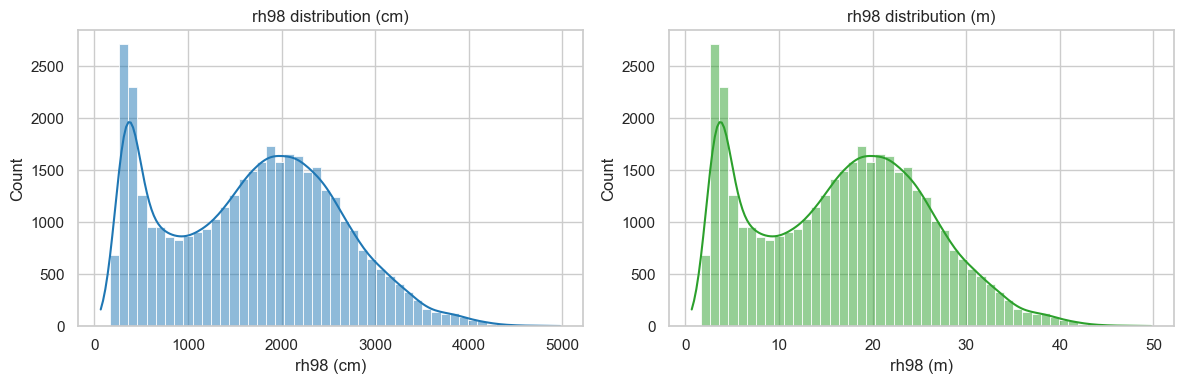

Top 10 columns by missing fraction (train):
rh98                         0.0
cv_61_google.embedding_nl    0.0
cv_2_google.embedding_nl     0.0
cv_18_google.embedding_nl    0.0
cv_38_google.embedding_nl    0.0
cv_10_google.embedding_nl    0.0
cv_53_google.embedding_nl    0.0
cv_57_google.embedding_nl    0.0
cv_60_google.embedding_nl    0.0
cv_26_google.embedding_nl    0.0
dtype: float64


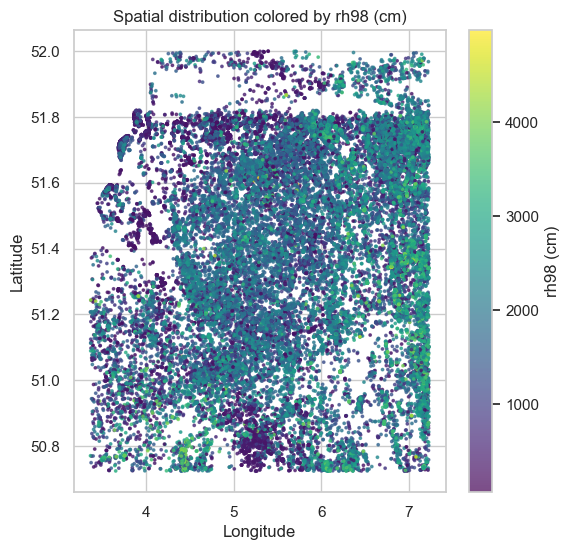

Top 10 positively correlated with rh98:
rh98                         1.000000
cv_21_google.embedding_nl    0.656129
cv_56_google.embedding_nl    0.610994
cv_43_google.embedding_nl    0.552400
cv_46_google.embedding_nl    0.530688
cv_8_google.embedding_nl     0.486159
cv_58_google.embedding_nl    0.457733
cv_11_google.embedding_nl    0.451281
cv_47_google.embedding_nl    0.387030
cv_61_google.embedding_nl    0.382092
Name: rh98, dtype: float64

Top 10 negatively correlated with rh98:
cv_23_google.embedding_nl   -0.330668
cv_38_google.embedding_nl   -0.341223
cv_36_google.embedding_nl   -0.346191
cv_27_google.embedding_nl   -0.415023
cv_45_google.embedding_nl   -0.458236
cv_41_google.embedding_nl   -0.483524
cv_52_google.embedding_nl   -0.508514
cv_37_google.embedding_nl   -0.539343
cv_40_google.embedding_nl   -0.543126
cv_29_google.embedding_nl   -0.609134
Name: rh98, dtype: float64


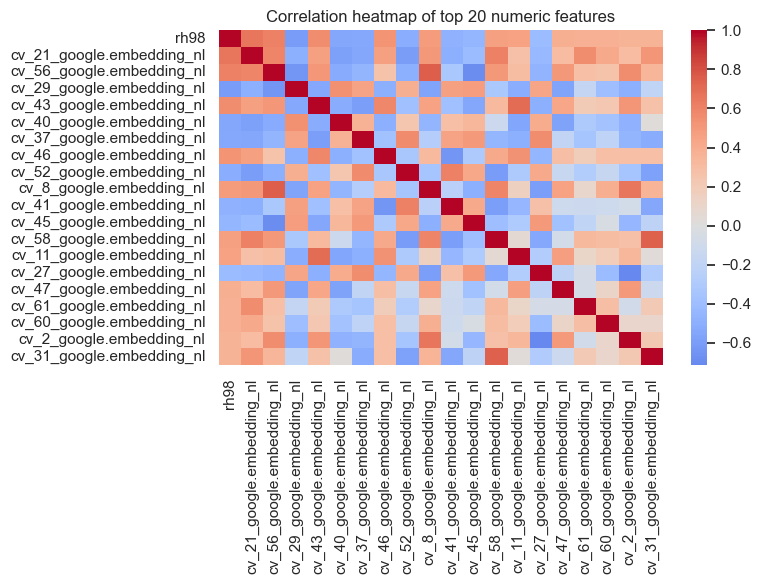

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


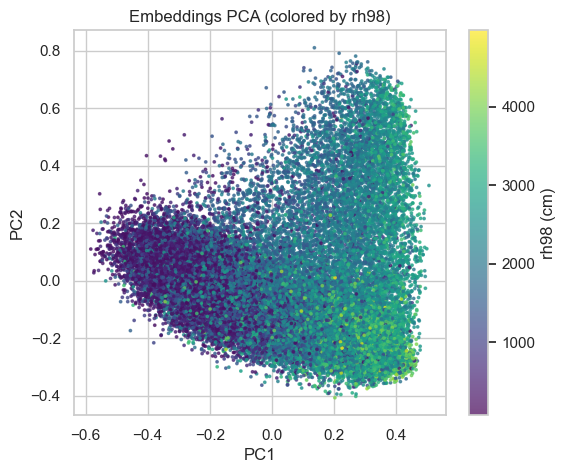

In [5]:
# 1) Target distribution (cm and meters)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(train[TARGET_COL].dropna(), bins=50, kde=True, ax=axes[0], color='tab:blue')
axes[0].set_title('rh98 distribution (cm)')
axes[0].set_xlabel('rh98 (cm)')

sns.histplot(train[TARGET_COL].dropna() / 100.0, bins=50, kde=True, ax=axes[1], color='tab:green')
axes[1].set_title('rh98 distribution (m)')
axes[1].set_xlabel('rh98 (m)')
plt.tight_layout()
plt.show()

# 2) Missingness overview
missing_train = train.isna().mean().sort_values(ascending=False)
print('Top 10 columns by missing fraction (train):')
print(missing_train.head(10))

# 3) Spatial scatter (lon-lat colored by rh98)
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(train[LON_COL], train[LAT_COL], c=train[TARGET_COL], s=3, cmap='viridis', alpha=0.7)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Spatial distribution colored by rh98 (cm)')
cb = plt.colorbar(sc, ax=ax)
cb.set_label('rh98 (cm)')
plt.show()

# 4) Correlation of top embedding features with target
# Compute correlations for numeric features to avoid memory blowup
numeric_cols = train.select_dtypes(include=[np.number]).columns
corr_with_target = train[numeric_cols].corr()[TARGET_COL].dropna().sort_values(ascending=False)
print('Top 10 positively correlated with rh98:')
print(corr_with_target.head(10))
print('\nTop 10 negatively correlated with rh98:')
print(corr_with_target.tail(10))

# Small heatmap of top 20 features by |correlation|
abs_top = corr_with_target.abs().sort_values(ascending=False).head(20).index
corr_mat = train[list(abs_top)].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, cmap='coolwarm', center=0)
plt.title('Correlation heatmap of top 20 numeric features')
plt.tight_layout()
plt.show()

# 5) PCA on embeddings for quick structure view (first 2 PCs)
if len(embed_cols) > 2:
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_embed = train[embed_cols].fillna(0.0).values
    pcs = pca.fit_transform(X_embed)
    fig, ax = plt.subplots(figsize=(6, 5))
    sc = ax.scatter(pcs[:, 0], pcs[:, 1], c=train[TARGET_COL], s=3, cmap='viridis', alpha=0.7)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('Embeddings PCA (colored by rh98)')
    cb = plt.colorbar(sc, ax=ax)
    cb.set_label('rh98 (cm)')
    plt.show()
else:
    print('Not enough embedding columns to run PCA EDA.')


## Cross-validation utilities
- Standard KFold (randomized)
- Spatial GroupKFold using KMeans on (lon, lat)
- Metric: RMSE in cm and meters


In [6]:
def rmse_cm(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def to_meters(cm):
    return cm / 100.0

def make_cv_splits(X, coords, use_spatial=True, n_splits=5, n_groups=25, random_state=RANDOM_STATE):
    if use_spatial:
        km = KMeans(n_clusters=n_groups, random_state=random_state, n_init='auto')
        groups = km.fit_predict(coords.values)
        gkf = GroupKFold(n_splits=n_splits)
        splits = list(gkf.split(X, None, groups))
        return splits, groups
    else:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        splits = list(kf.split(X))
        return splits, None

cv_splits, groups = make_cv_splits(X, coords, use_spatial=USE_SPATIAL_CV, n_splits=N_SPLITS, n_groups=N_SPATIAL_GROUPS)
print('CV folds:', len(cv_splits), 'Spatial groups used:' , groups is not None)


CV folds: 5 Spatial groups used: True


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


## Model factories and CV evaluation
Pipelines with scaling where appropriate; small randomized hyperparameter search for quick baselines.


## Neural network (MLP) model
We train a multi-layer perceptron on the AEF embeddings (and any extra numeric features). Early stopping and Adam optimizer are used via scikit-learn's `MLPRegressor`. This is well-suited for dense vector embeddings.


In [7]:
# Guard: define CV helper functions if missing (run_cv, oof_predictions, fit_full_and_predict)
if 'run_cv' not in globals():
    from sklearn.model_selection import RandomizedSearchCV

    def run_cv(model, X, y, splits, param_dist=None, n_iter=15, scoring='neg_root_mean_squared_error'):
        if param_dist is not None:
            search = RandomizedSearchCV(
                estimator=model,
                param_distributions=param_dist,
                n_iter=n_iter,
                scoring=scoring,
                cv=splits,
                n_jobs=N_JOBS,
                random_state=RANDOM_STATE,
                refit=True,
                verbose=0
            )
            search.fit(X, y)
            best_est = search.best_estimator_
            best_params = search.best_params_
            best_cv_rmse = -search.best_score_
            return best_est, best_params, best_cv_rmse
        else:
            oof = np.zeros(len(y))
            for tr, va in splits:
                est = model
                est.fit(X.iloc[tr], y[tr])
                pred = est.predict(X.iloc[va])
                oof[va] = pred
            rmse = rmse_cm(y, oof)
            model.fit(X, y)
            return model, {}, rmse

    def oof_predictions(estimator, X, y, splits):
        oof = np.zeros(len(y))
        for tr, va in splits:
            est = estimator
            est.fit(X.iloc[tr], y[tr])
            oof[va] = est.predict(X.iloc[va])
        return oof

    def fit_full_and_predict(estimator, X, y, X_test):
        estimator.fit(X, y)
        return estimator.predict(X_test)


In [8]:
# MLPRegressor on embeddings + extra numeric features with scaling
from sklearn.neural_network import MLPRegressor

def mlp_model():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', MLPRegressor(
            hidden_layer_sizes=(256, 128),
            activation='relu',
            solver='adam',
            learning_rate='constant',
            learning_rate_init=1e-3,
            batch_size=256,
            early_stopping=True,
            max_iter=400,
            random_state=RANDOM_STATE,
            verbose=False
        ))
    ])
    param_dist = {
        'model__hidden_layer_sizes': [(128,), (256,), (256,128), (512,256)],
        'model__alpha': np.logspace(-6, -2, 5),
        'model__learning_rate_init': [1e-4, 3e-4, 1e-3, 3e-3],
        'model__batch_size': [128, 256, 512],
        'model__max_iter': [300, 400, 600],
        'model__early_stopping': [True]
    }
    return pipe, param_dist

mlp, mlp_dist = mlp_model()
mlp_best, mlp_params, mlp_cv = run_cv(mlp, X, y, cv_splits, mlp_dist, n_iter=20)
results.append({'model': 'MLP', 'rmse_cm': mlp_cv, 'params': mlp_params})
print('MLP RMSE (cm):', round(mlp_cv, 2))

# Refresh results_df to include MLP
results_df = pd.DataFrame(results).sort_values('rmse_cm')
display(results_df)

# Keep best estimator reference for ensembling usage
mlp_best_estimator = mlp_best

# Predict test with the tuned MLP for ensembling
mlp_test_pred = fit_full_and_predict(mlp_best_estimator, X, y, X_test)


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-

KeyboardInterrupt: 

## Extended XGBoost sweep
We try a small grid over `max_depth` and `learning_rate` (and a couple of tree-level params), using the same CV splits. The best CV score is tracked and appended to `results`.


In [ ]:
if XGB_AVAILABLE:
    best_cfg = None
    best_rmse = float('inf')
    best_est = None

    depth_grid = [4, 6, 8, 10]
    lr_grid = [0.01, 0.03, 0.1]
    subsample_grid = [0.7, 0.85, 1.0]
    colsample_grid = [0.6, 0.8, 1.0]

    for md in depth_grid:
        for lr in lr_grid:
            for ss in subsample_grid:
                for cs in colsample_grid:
                    model = xgb.XGBRegressor(
                        random_state=RANDOM_STATE,
                        n_estimators=1000,
                        max_depth=md,
                        learning_rate=lr,
                        subsample=ss,
                        colsample_bytree=cs,
                        tree_method='hist',
                        n_jobs=N_JOBS
                    )
                    # Evaluate with CV
                    oof = np.zeros(len(y))
                    for tr, va in cv_splits:
                        model.fit(X.iloc[tr], y[tr])
                        oof[va] = model.predict(X.iloc[va])
                    rmse = rmse_cm(y, oof)
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_cfg = {'max_depth': md, 'learning_rate': lr, 'subsample': ss, 'colsample_bytree': cs}
                        best_est = model
                    print(f"XGB depth={md} lr={lr} ss={ss} cs={cs} -> RMSE {rmse:.2f}")

    print('Best XGB config:', best_cfg, 'RMSE (cm):', round(best_rmse, 2))
    results.append({'model': 'XGBoost_sweep', 'rmse_cm': float(best_rmse), 'params': best_cfg})
    results_df = pd.DataFrame(results).sort_values('rmse_cm')
    display(results_df)

    # Predict test
    xgb_sweep_test_pred = fit_full_and_predict(best_est, X, y, X_test)
else:
    print('XGBoost not available; skip sweep.')


## Lasso and Elastic Net baselines
We compare linear sparse models with L1 (Lasso) and L1+L2 (Elastic Net) penalties, using standardized inputs and randomized search for hyperparameters.


In [ ]:
# Lasso
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(random_state=RANDOM_STATE, max_iter=2000))
])
lasso_dist = {
    'model__alpha': np.logspace(-4, 1, 20)
}
lasso_best, lasso_params, lasso_cv = run_cv(lasso_pipe, X, y, cv_splits, lasso_dist, n_iter=20)
results.append({'model': 'Lasso', 'rmse_cm': lasso_cv, 'params': lasso_params})
print('Lasso RMSE (cm):', round(lasso_cv, 2))

# Elastic Net
enet_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet(random_state=RANDOM_STATE, max_iter=3000))
])
enet_dist = {
    'model__alpha': np.logspace(-4, 1, 20),
    'model__l1_ratio': np.linspace(0.05, 0.95, 10)
}
enet_best, enet_params, enet_cv = run_cv(enet_pipe, X, y, cv_splits, enet_dist, n_iter=30)
results.append({'model': 'ElasticNet', 'rmse_cm': enet_cv, 'params': enet_params})
print('ElasticNet RMSE (cm):', round(enet_cv, 2))

results_df = pd.DataFrame(results).sort_values('rmse_cm')
display(results_df)

# Predict test for each to include in optional ensemble variants
lasso_test_pred = fit_full_and_predict(lasso_best, X, y, X_test)
enet_test_pred = fit_full_and_predict(enet_best, X, y, X_test)


## PyTorch MLP (MPS GPU-accelerated)
We train a lightweight PyTorch MLP on embeddings + numeric features with Apple Silicon acceleration via MPS if available. This block performs CV, reports OOF RMSE, and produces test predictions. The ensemble step will consider this model as well.


In [9]:
# If PyTorch is not installed, uncomment the next line
# %pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

import math as _math
import time
from typing import Tuple

try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

print({'TORCH_AVAILABLE': TORCH_AVAILABLE})

if TORCH_AVAILABLE:
    # Device: prefer MPS on Apple Silicon, else CUDA, else CPU
    if torch.backends.mps.is_available():
        DEVICE = torch.device('mps')
    elif torch.cuda.is_available():
        DEVICE = torch.device('cuda')
    else:
        DEVICE = torch.device('cpu')
    print('Torch device:', DEVICE)

    class NpDataset(Dataset):
        def __init__(self, X_np, y_np=None):
            self.X = X_np.astype(np.float32)
            self.y = None if y_np is None else y_np.astype(np.float32)
        def __len__(self):
            return len(self.X)
        def __getitem__(self, idx):
            if self.y is None:
                return self.X[idx]
            return self.X[idx], self.y[idx]

    class MLP(nn.Module):
        def __init__(self, in_dim: int, hidden: Tuple[int, ...] = (512, 256, 128), dropout=0.1):
            super().__init__()
            layers = []
            prev = in_dim
            for h in hidden:
                layers += [nn.Linear(prev, h), nn.ReLU(inplace=True), nn.Dropout(dropout)]
                prev = h
            layers += [nn.Linear(prev, 1)]
            self.net = nn.Sequential(*layers)
        def forward(self, x):
            return self.net(x).squeeze(-1)

    def train_one_fold(X_tr, y_tr, X_va, y_va, *,
                       epochs=50, batch_size=1024, lr=3e-3,
                       weight_decay=1e-5, hidden=(512,256,128),
                       dropout=0.1):
        model = MLP(X_tr.shape[1], hidden, dropout).to(DEVICE)
        opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
        loss_fn = nn.MSELoss()

        ds_tr = NpDataset(X_tr, y_tr)
        ds_va = NpDataset(X_va, y_va)
        dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, num_workers=0)
        dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=0)

        best_rmse = float('inf')
        best_state = None
        patience, no_improve = 8, 0

        for ep in range(epochs):
            model.train()
            for xb, yb in dl_tr:
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE)
                opt.zero_grad(set_to_none=True)
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                opt.step()
            sched.step()

            # validation
            model.eval()
            va_preds = []
            with torch.no_grad():
                for xb, yb in dl_va:
                    xb = xb.to(DEVICE)
                    pred = model(xb)
                    va_preds.append(pred.cpu().numpy())
            va_pred = np.concatenate(va_preds)
            rmse = _math.sqrt(np.mean((va_pred - y_va) ** 2))
            if rmse < best_rmse - 1e-3:
                best_rmse = rmse
                best_state = {k: v.cpu() for k, v in model.state_dict().items()}
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    break
        if best_state is not None:
            model.load_state_dict(best_state)
        return model, best_rmse

    # Run CV for Torch MLP
    X_np = X.values.astype(np.float32)
    y_np = y.astype(np.float32)

    oof_torch = np.zeros(len(y_np), dtype=np.float32)
    fold_rmses = []
    start = time.time()
    for fold_idx, (tr, va) in enumerate(cv_splits):
        model, rmse = train_one_fold(
            X_np[tr], y_np[tr], X_np[va], y_np[va],
            epochs=60, batch_size=2048, lr=3e-3, weight_decay=1e-5,
            hidden=(512,256,128), dropout=0.1,
        )
        fold_rmses.append(rmse)
        # predict val
        model.eval()
        with torch.no_grad():
            oof_torch[va] = model(torch.from_numpy(X_np[va]).to(DEVICE)).cpu().numpy()
    total_rmse = _math.sqrt(np.mean((oof_torch - y_np) ** 2))
    dur = time.time() - start
    print(f'Torch MLP OOF RMSE (cm): {total_rmse:.2f}  | time: {dur:.1f}s')

    # Fit full and predict test
    model_full, _ = train_one_fold(
        X_np, y_np,
        X_np[:min(1024, len(X_np))], y_np[:min(1024, len(X_np))],  # dummy val
        epochs=80, batch_size=4096, lr=2e-3, weight_decay=1e-5,
        hidden=(512,256,128), dropout=0.1,
    )
    model_full.eval()
    X_test_np = X_test.values.astype(np.float32)
    with torch.no_grad():
        torch_test_pred = model_full(torch.from_numpy(X_test_np).to(DEVICE)).cpu().numpy()

    # Register in results and for ensembling
    results.append({'model': 'TorchMLP', 'rmse_cm': float(total_rmse), 'params': {
        'hidden': [512,256,128], 'dropout': 0.1, 'lr': 3e-3, 'epochs': 60
    }})
    results_df = pd.DataFrame(results).sort_values('rmse_cm')
    display(results_df)

    # Make available like other models
    torch_mlp_oof = oof_torch
    torch_mlp_test_pred = torch_test_pred
else:
    print('PyTorch not available. Install torch to enable GPU-accelerated MLP (Apple MPS supported).')


{'TORCH_AVAILABLE': True}
Torch device: mps
Torch MLP OOF RMSE (cm): 548.12  | time: 29.6s


,model,rmse_cm,params
0,TorchMLP,548.121394,"{'hidden': [512, 256, 128], 'dropout': 0.1, 'l..."


In [11]:
def ridge_model():
    pipe = Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('model', Ridge(random_state=RANDOM_STATE))
    ])
    param_dist = {
        'model__alpha': np.logspace(-3, 3, 13)
    }
    return pipe, param_dist

def pls_model():
    # PLS is robust for correlated embeddings
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', PLSRegression())
    ])
    # Components between 2 and min(30, n_features)
    max_comp = 30
    param_dist = {
        'model__n_components': list(range(2, min(max_comp, X.shape[1]) + 1, 2))
    }
    return pipe, param_dist

def rf_model():
    model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS)
    param_dist = {
        'n_estimators': [200, 400, 800],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    return model, param_dist

def gbr_model():
    model = GradientBoostingRegressor(random_state=RANDOM_STATE)
    param_dist = {
        'n_estimators': [200, 400, 800],
        'learning_rate': [0.01, 0.03, 0.1, 0.2],
        'max_depth': [2, 3, 4]
    }
    return model, param_dist

def xgb_model():
    if not XGB_AVAILABLE:
        return None, None
    model = xgb.XGBRegressor(
        random_state=RANDOM_STATE,
        n_estimators=800,
        tree_method='hist',
        n_jobs=N_JOBS
    )
    param_dist = {
        'max_depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.03, 0.1],
        'subsample': [0.7, 0.85, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    return model, param_dist

def run_cv(model, X, y, splits, param_dist=None, n_iter=15, scoring='neg_root_mean_squared_error'):
    # Use randomized search if param_dist provided
    if param_dist is not None:
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=n_iter,
            scoring=scoring,
            cv=splits,
            n_jobs=N_JOBS,
            random_state=RANDOM_STATE,
            refit=True,
            verbose=0
        )
        search.fit(X, y)
        best_est = search.best_estimator_
        best_params = search.best_params_
        best_cv_rmse = -search.best_score_
        return best_est, best_params, best_cv_rmse
    else:
        # Fit with provided model and compute CV RMSE manually
        oof = np.zeros(len(y))
        for tr, va in splits:
            est = model
            est.fit(X[tr] if isinstance(X, np.ndarray) else X.iloc[tr], y[tr])
            pred = est.predict(X[va] if isinstance(X, np.ndarray) else X.iloc[va])
            oof[va] = pred
        rmse = rmse_cm(y, oof)
        model.fit(X, y)
        return model, {}, rmse

def oof_predictions(estimator, X, y, splits):
    oof = np.zeros(len(y))
    for tr, va in splits:
        est = estimator
        est.fit(X.iloc[tr], y[tr])
        oof[va] = est.predict(X.iloc[va])
    return oof

def fit_full_and_predict(estimator, X, y, X_test):
    estimator.fit(X, y)
    return estimator.predict(X_test)

def linear_bias_correction(y_true, y_pred):
    # Fit y_true = a + b*y_pred
    lr = LinearRegression()
    lr.fit(y_pred.reshape(-1,1), y_true)
    a = float(lr.intercept_)
    b = float(lr.coef_[0])
    return a, b

def apply_bias(y_pred, a, b):
    return a + b * y_pred


## Baseline and model training
- Baseline mean predictor
- Ridge, PLS, Random Forest, Gradient Boosting, optional XGBoost
- Spatial CV by default for robustness


In [13]:
results = []

# Baseline: mean
mean_pred = np.full_like(y, fill_value=y.mean(), dtype=float)
rmse_mean = rmse_cm(y, mean_pred)
results.append({'model': 'Mean', 'rmse_cm': rmse_mean, 'params': {}})
print('Baseline Mean RMSE (cm):', round(rmse_mean, 2), '=>', round(to_meters(rmse_mean), 3), 'm')

# Ridge
ridge, ridge_dist = ridge_model()
ridge_best, ridge_params, ridge_cv = run_cv(ridge, X, y, cv_splits, ridge_dist, n_iter=20)
results.append({'model': 'Ridge', 'rmse_cm': ridge_cv, 'params': ridge_params})
print('Ridge RMSE (cm):', round(ridge_cv, 2))

# PLS
pls, pls_dist = pls_model()
pls_best, pls_params, pls_cv = run_cv(pls, X, y, cv_splits, pls_dist, n_iter=15)
results.append({'model': 'PLS', 'rmse_cm': pls_cv, 'params': pls_params})
print('PLS RMSE (cm):', round(pls_cv, 2))

# Random Forest
rf, rf_dist = rf_model()
rf_best, rf_params, rf_cv = run_cv(rf, X, y, cv_splits, rf_dist, n_iter=20)
results.append({'model': 'RandomForest', 'rmse_cm': rf_cv, 'params': rf_params})
print('RF RMSE (cm):', round(rf_cv, 2))

# Gradient Boosting
gbr, gbr_dist = gbr_model()
gbr_best, gbr_params, gbr_cv = run_cv(gbr, X, y, cv_splits, gbr_dist, n_iter=15)
results.append({'model': 'GradientBoosting', 'rmse_cm': gbr_cv, 'params': gbr_params})
print('GBR RMSE (cm):', round(gbr_cv, 2))

# XGBoost (optional)
if XGB_AVAILABLE:
    xgb_m, xgb_dist = xgb_model()
    xgb_best, xgb_params, xgb_cv = run_cv(xgb_m, X, y, cv_splits, xgb_dist, n_iter=20)
    results.append({'model': 'XGBoost', 'rmse_cm': xgb_cv, 'params': xgb_params})
    print('XGB RMSE (cm):', round(xgb_cv, 2))
else:
    print('XGBoost not available; install xgboost to enable.')

results_df = pd.DataFrame(results).sort_values('rmse_cm')
display(results_df)
best_row = results_df.iloc[0]
print('Best model:', best_row['model'], 'RMSE (cm):', round(best_row['rmse_cm'], 2))


Baseline Mean RMSE (cm): 916.61 => 9.166 m


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 13 is smaller than n_iter=20. Running 13 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/homebrew/lib/

Ridge RMSE (cm): 549.19


/opt/homebrew/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:477: RuntimeWarning: divide by zero encountered in matmul
  y_pred = X @ self.coef_.T + self.intercept_
/opt/homebrew/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:477: RuntimeWarning: overflow encountered in matmul
  y_pred = X @ self.coef_.T + self.intercept_
/opt/homebrew/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:477: RuntimeWarning: invalid value encountered in matmul
  y_pred = X @ self.coef_.T + self.intercept_
/opt/homebrew/lib/python3.11/site-packages/scipy/linalg/_basic.py:1648: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/opt/homebrew/lib/python3.11/site-packages/scipy/linalg/_basic.py:1648: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/opt/homebrew/lib/python3.11/site-packages/scipy/linalg/_basic.py:1648: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj()

PLS RMSE (cm): 549.29


/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RF RMSE (cm): 554.05
GBR RMSE (cm): 550.7


/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGB RMSE (cm): 545.73


,model,rmse_cm,params
5,XGBoost,545.731521,"{'subsample': 0.7, 'max_depth': 8, 'learning_r..."
1,Ridge,549.186114,{'model__alpha': 316.22776601683796}
2,PLS,549.289378,{'model__n_components': 16}
4,GradientBoosting,550.697566,"{'n_estimators': 800, 'max_depth': 4, 'learnin..."
3,RandomForest,554.054792,"{'n_estimators': 800, 'min_samples_split': 5, ..."
0,Mean,916.612839,{}


Best model: XGBoost RMSE (cm): 545.73


## Ensembling and bias correction
- Build out-of-fold predictions for top models
- Average ensemble
- Fit optional linear calibration (a + b ŷ) and report it for documentation


In [ ]:
# Choose top models for OOF/ensemble (up to 3-4)
top_models = results_df['model'].tolist()[:4]
print('Top models for ensemble:', top_models)

model_map = {}
if 'Ridge' in top_models: model_map['Ridge'] = ridge_best
if 'PLS' in top_models: model_map['PLS'] = pls_best
if 'RandomForest' in top_models: model_map['RandomForest'] = rf_best
if 'GradientBoosting' in top_models: model_map['GradientBoosting'] = gbr_best
if 'XGBoost' in top_models and XGB_AVAILABLE: model_map['XGBoost'] = xgb_best

oof_stack = []
for name, est in model_map.items():
    oof_pred = oof_predictions(est, X, y, cv_splits)
    rmse = rmse_cm(y, oof_pred)
    print(f'{name} OOF RMSE (cm):', round(rmse, 2))
    oof_stack.append(oof_pred)

if len(oof_stack) > 0:
    oof_stack = np.vstack(oof_stack)
    oof_ens = oof_stack.mean(axis=0)
    rmse_ens = rmse_cm(y, oof_ens)
    print('Ensemble OOF RMSE (cm):', round(rmse_ens, 2), '=>', round(to_meters(rmse_ens), 3), 'm')

    # Bias correction from ensemble
    a_ens, b_ens = linear_bias_correction(y, oof_ens)
    print('Bias correction (ensemble): a =', round(a_ens, 2), 'b =', round(b_ens, 4))
else:
    oof_ens = None
    a_ens, b_ens = 0.0, 1.0
    print('No models available for ensembling.')

bias_report = {
    'method': 'linear',
    'a_intercept_cm': float(a_ens),
    'b_slope': float(b_ens),
    'note': 'Fit on OOF predictions: y_true = a + b*y_pred.'
}
print('Bias report:', json.dumps(bias_report, indent=2))


## Train on full data and predict test
- Train each selected model on full training data
- Average predictions (ensemble)
- Apply bias correction (optional)
- Save predictions with coordinates for traceability


In [ ]:
test_preds = []
for name, est in model_map.items():
    yhat_test = fit_full_and_predict(est, X, y, X_test)
    test_preds.append(yhat_test)
    print('Fitted', name)

if len(test_preds) > 0:
    test_pred_ens = np.vstack(test_preds).mean(axis=0)
else:
    test_pred_ens = np.full(len(X_test), y.mean())

# Apply bias correction from ensemble OOF
test_pred_ens_bc = apply_bias(test_pred_ens, a_ens, b_ens)

out = test[[LON_COL, LAT_COL]].copy()
out['pred_cm'] = test_pred_ens
out['pred_cm_bias_corrected'] = test_pred_ens_bc
out['pred_m'] = out['pred_cm'] / 100.0
out['pred_m_bias_corrected'] = out['pred_cm_bias_corrected'] / 100.0

PRED_PATH = BASE_DIR / 'test_predictions.csv'
out.to_csv(PRED_PATH, index=False)
print('Saved predictions to:', PRED_PATH)

# Save a brief method note for submission documentation
NOTE_PATH = BASE_DIR / 'model_note.json'
note = {
    'cv': {
        'type': 'GroupKFold' if USE_SPATIAL_CV else 'KFold',
        'n_splits': N_SPLITS,
        'n_spatial_groups': N_SPATIAL_GROUPS if USE_SPATIAL_CV else None
    },
    'top_models': top_models,
    'results': results_df.to_dict(orient='records'),
    'bias_correction': bias_report,
    'features': {
        'n_embeddings': len([c for c in feature_cols if 'embedding' in c.lower()]),
        'n_extra_numeric': len([c for c in feature_cols if 'embedding' not in c.lower()])
    }
}
with open(NOTE_PATH, 'w') as f:
    json.dump(note, f, indent=2)
print('Saved model note to:', NOTE_PATH)


## Tips, checks, and next steps
- **Data integrity**: ensure `rh98` is in cm; report meters for context. Expect ~64 embedding columns; adjust regex if needed.
- **CV**: prefer `USE_SPATIAL_CV=True` for robust generalization; set `N_SPATIAL_GROUPS` ~20–40.
- **Models**: Ridge/PLS are strong baselines; RF/GBR capture nonlinearities; add XGBoost if available.
- **Hyperparameters**: increase `n_iter` and expand grids for better accuracy at higher cost.
- **Bias correction**: we fit `y = a + b ŷ` on OOF; include `a`, `b` in submission note.
- **Explainability**: permutation importance or SHAP for tree models.
- **Reproducibility**: fix seeds; save `model_note.json` and `test_predictions.csv`.
- **AEF context**: see the AEF chapter for embedding properties and consider eco-type-specific models.


In [ ]:
# Safety pass: rewrite predictions with available coordinate columns
if 'test_pred_ens' in globals():
    if 'HAVE_COORDS_TEST' in globals() and HAVE_COORDS_TEST:
        out_final = test[[LON_COL_TEST, LAT_COL_TEST]].copy()
        out_final.columns = ['lon', 'lat'] if set([LON_COL_TEST.lower(), LAT_COL_TEST.lower()]) == set(['lon', 'lat']) else [LON_COL_TEST, LAT_COL_TEST]
    else:
        out_final = pd.DataFrame()
    out_final['pred_cm'] = test_pred_ens
    if 'a_ens' in globals() and 'b_ens' in globals():
        out_final['pred_cm_bias_corrected'] = apply_bias(test_pred_ens, a_ens, b_ens)
        out_final['pred_m_bias_corrected'] = out_final['pred_cm_bias_corrected'] / 100.0
    out_final['pred_m'] = out_final['pred_cm'] / 100.0

    PRED_PATH = BASE_DIR / 'test_predictions.csv'
    out_final.to_csv(PRED_PATH, index=False)
    print('Rewrote predictions to:', PRED_PATH)
else:
    print('Skipping rewrite: test_pred_ens not found. Run model training cells first.')
